In [67]:
from collections import OrderedDict
import re
import os
import torch

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models1"
print(run_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
../models1


In [68]:
df = read_run_dir(run_dir)
df# list all the runs in our run_dir

run_path: ../models1/sparse_linear_regression/pretrained
run_path: ../models1/decision_tree/pretrained
run_path: ../models1/relu_2nn_regression/pretrained
run_path: ../models1/linear_regression/pretrained


,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
1,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
3,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
2,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
0,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [69]:


task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "pretrained"  # if you train more models12, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
print(run_path)

../models1/linear_regression/pretrained


In [70]:

recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

run_path: ../models1/linear_regression/pretrained
linear_regression_pretrained pretrained
run_path: ../models1/linear_regression/pretrained


100%|██████████| 15/15 [00:00<00:00, 201004.98it/s]

{'half_subspace': {'Transformer': {'mean': [0.9632429122924805, 0.9123161315917969, 0.7510465145111084, 0.6924034118652344, 0.6116585731506348, 0.4950979232788086, 0.39366726875305175, 0.31080701351165774, 0.20295586585998535, 0.1035406231880188, 0.03663731813430786, 0.011795975267887115, 0.005011618882417679, 0.003079252317547798, 0.0027918219566345215, 0.002493770234286785, 0.0021976608783006667, 0.002169094420969486, 0.0019014213234186173, 0.0015295283868908883, 0.0013808086514472961, 0.0011476188898086547, 0.0011712506413459778, 0.001076708547770977, 0.0009131195954978466, 0.0008459294214844704, 0.0006800353527069092, 0.0005611887201666832, 0.0005421477369964122, 0.0004785127006471157, 0.00043568005785346033, 0.0004106187727302313, 0.00037038370501250026, 0.0003815237432718277, 0.00034064881037920713, 0.00035692304372787477, 0.00038688082713633776, 0.0004218162037432194, 0.0003627842292189598, 0.00038797049783170225, 0.0003733177436515689], 'std': [1.4583826065063477, 1.52065773010

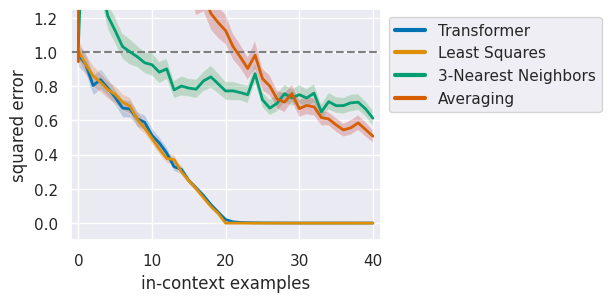

In [72]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
print(metrics)

_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
# print(models)
basic_plot(metrics["standard"], models=models)
plt.show()

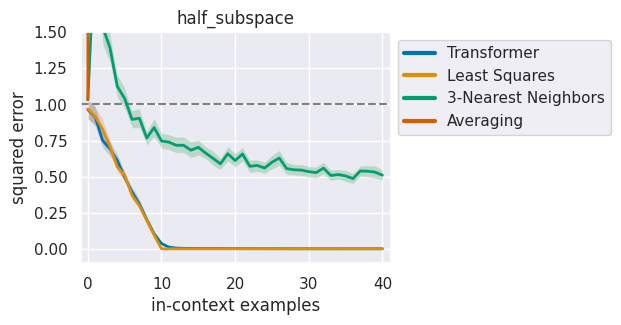

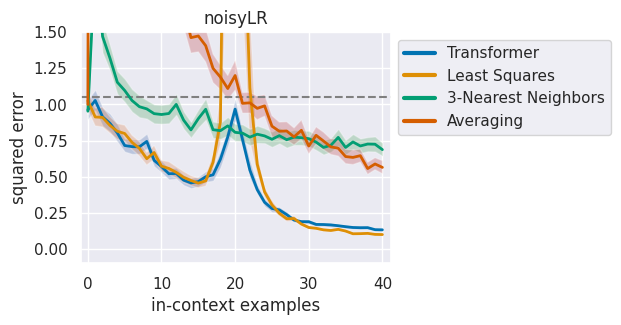

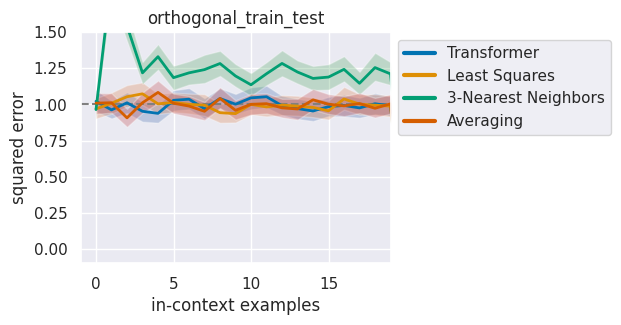

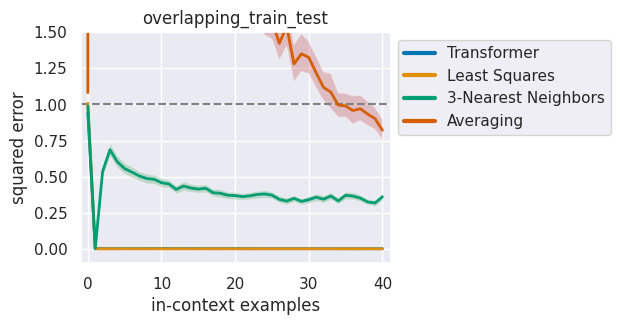

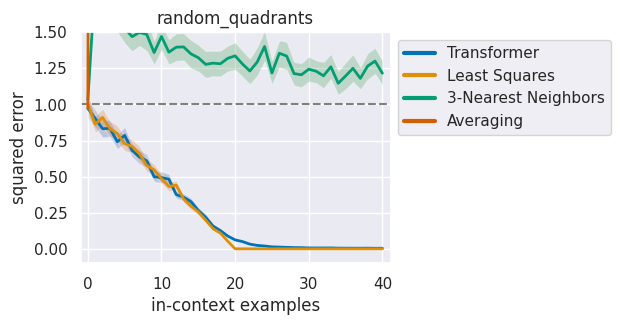

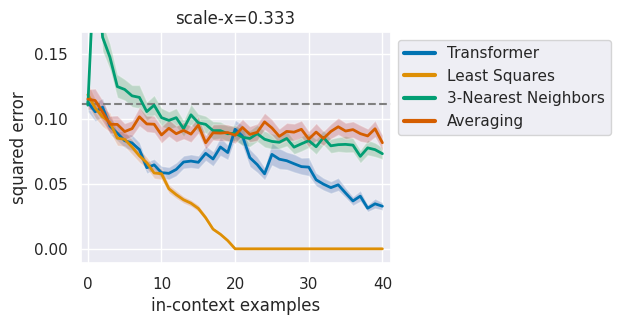

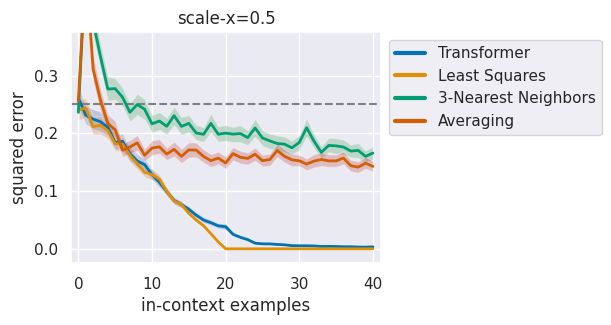

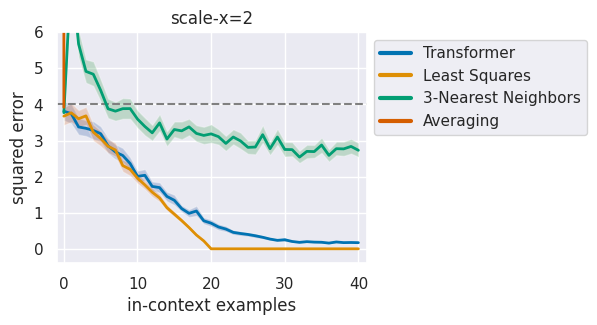

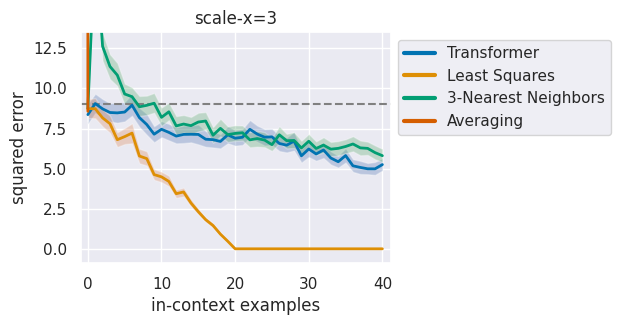

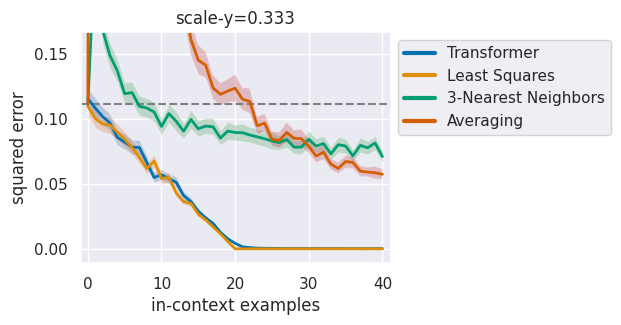

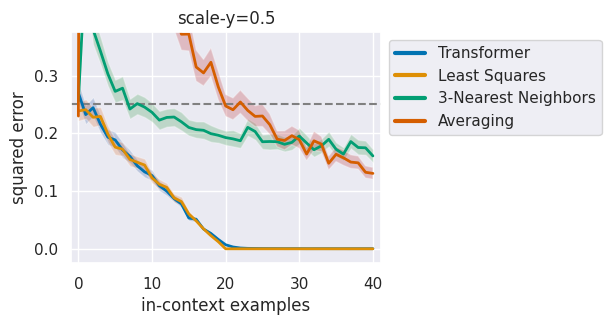

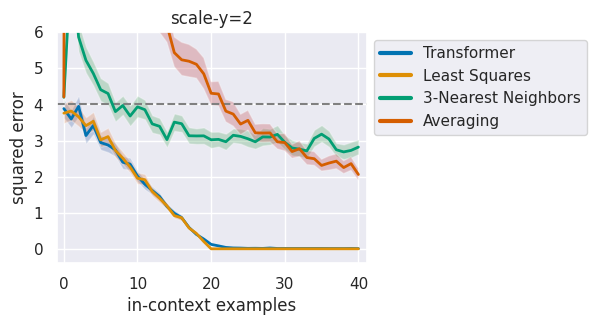

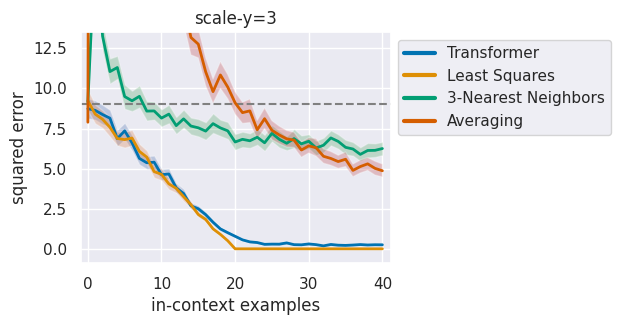

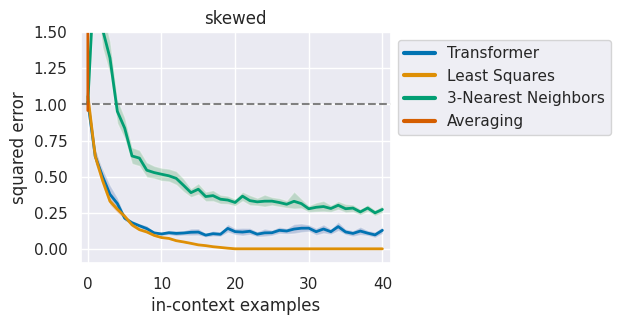

In [73]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [74]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [75]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

run_path: ../models1/linear_regression/pretrained


In [76]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [77]:
with torch.no_grad():
    pred = model(xs, ys)

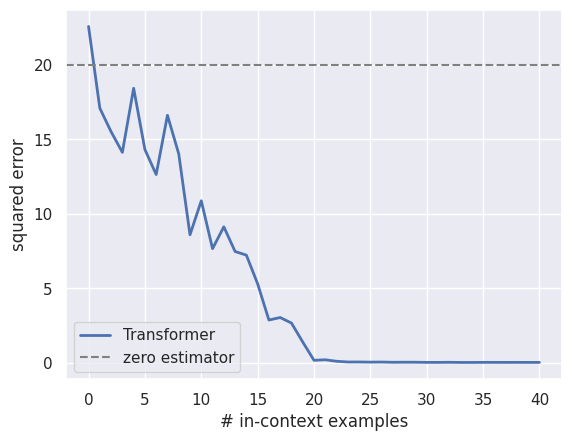

In [78]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [79]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

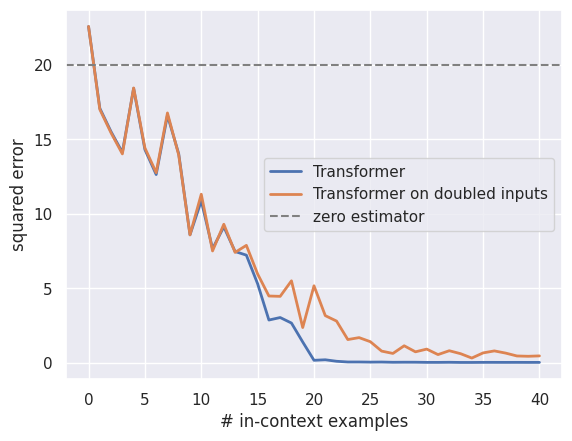

In [80]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.